In [94]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=1,
            latent_dims=10,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

(1310,)


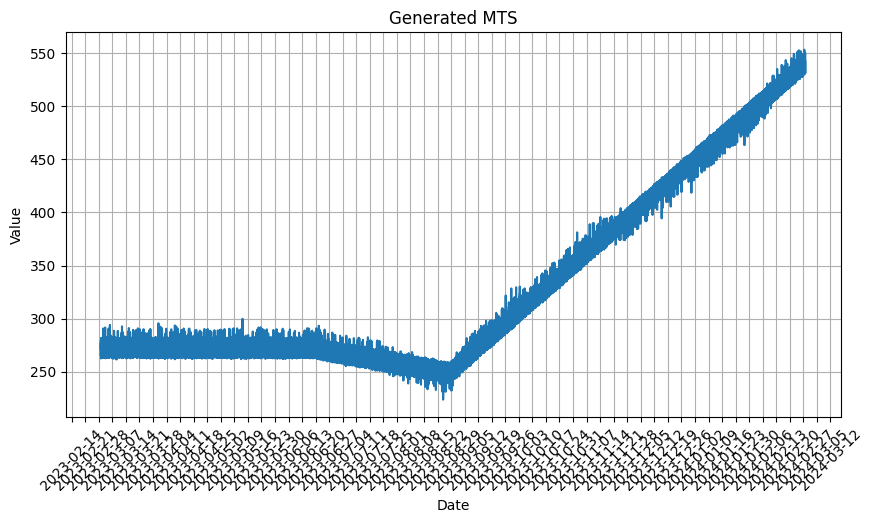

In [4]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=2,
                                                                            return_gen=True,
                                                                            anomalies=True)

In [5]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

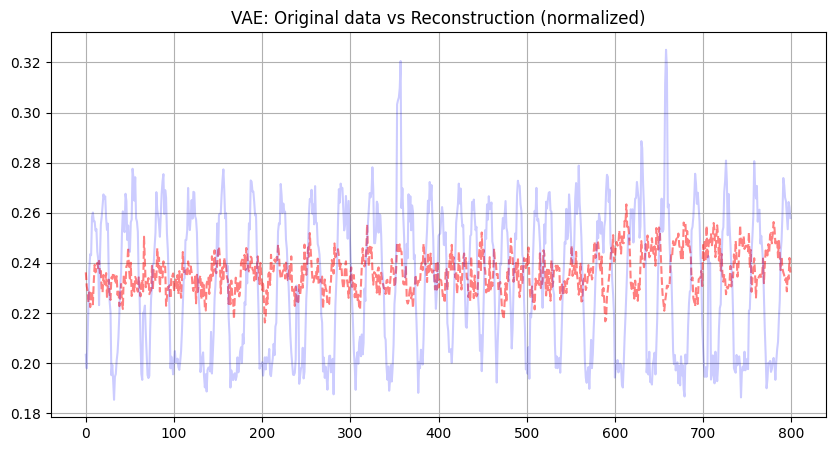

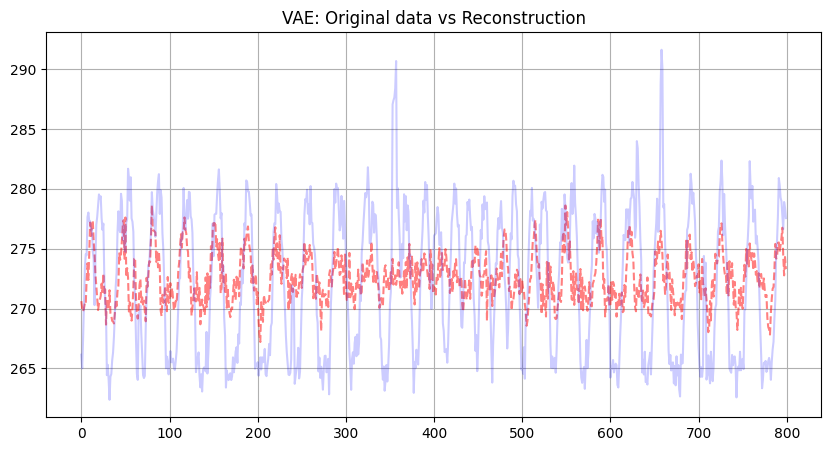

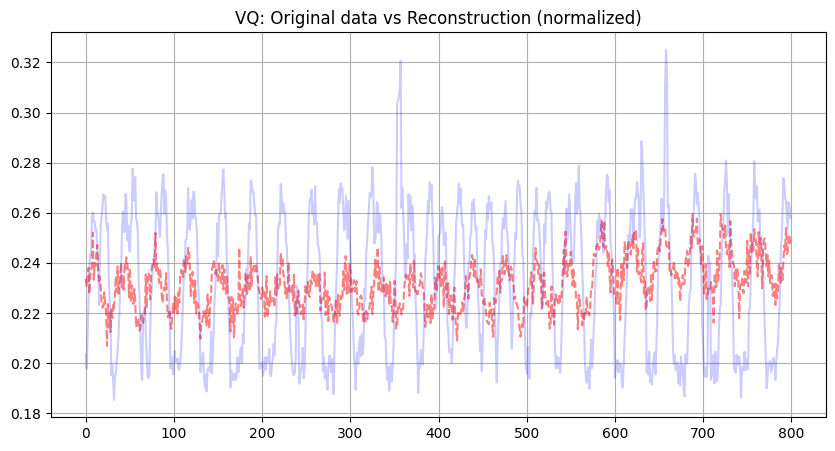

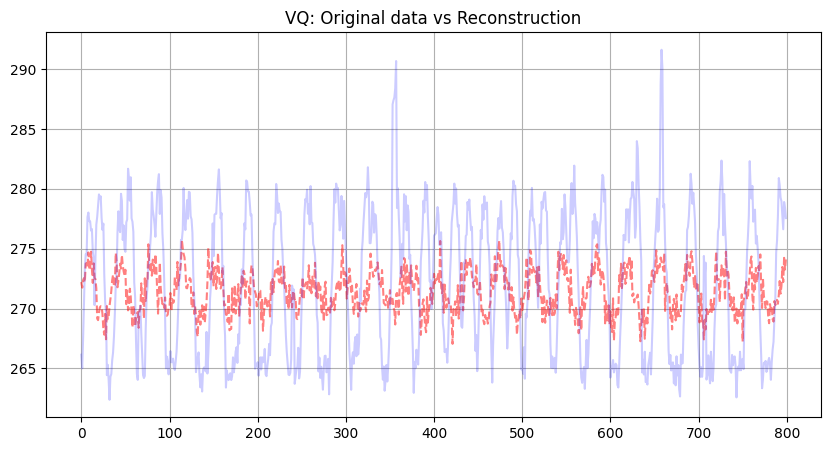

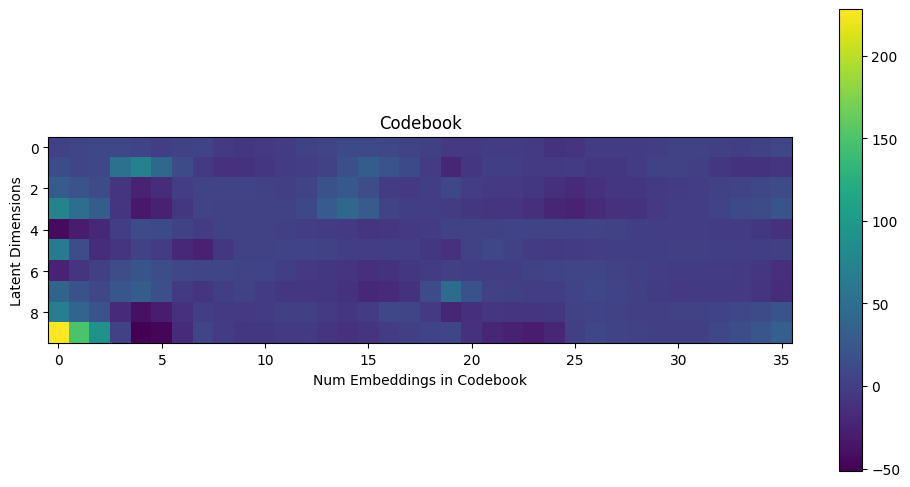

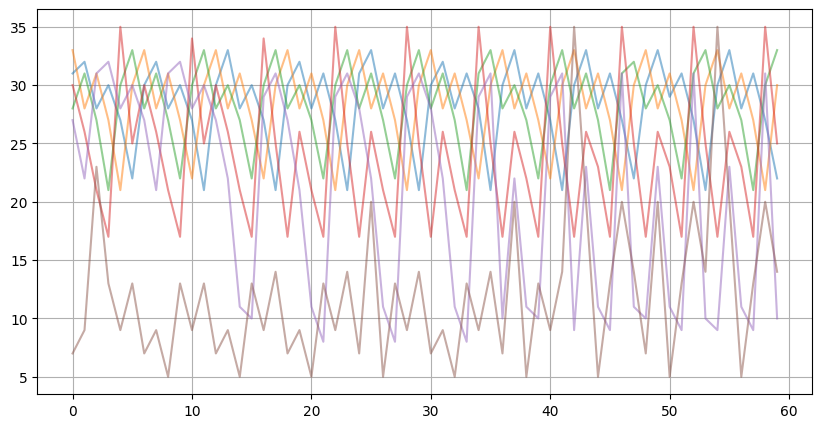

====> VAE: Sample 4901 Average loss: 0.0084
====> VQ: Sample 4901 Average loss: 0.0205
Train Epoch: 4902 [0/1 (0%)]	Loss: 1.190537	 True Loss: 172.627899
Train Epoch: 4902 [0/1 (0%)]	Loss: 2.870503	 True Loss: 416.222931
====> VAE: Sample 4902 Average loss: 0.0082
====> VQ: Sample 4902 Average loss: 0.0198
Train Epoch: 4903 [0/1 (0%)]	Loss: 1.202080	 True Loss: 174.301636
Train Epoch: 4903 [0/1 (0%)]	Loss: 2.764914	 True Loss: 400.912476
====> VAE: Sample 4903 Average loss: 0.0083
====> VQ: Sample 4903 Average loss: 0.0191
Train Epoch: 4904 [0/1 (0%)]	Loss: 1.257928	 True Loss: 182.399536
Train Epoch: 4904 [0/1 (0%)]	Loss: 2.825463	 True Loss: 409.692139
====> VAE: Sample 4904 Average loss: 0.0087
====> VQ: Sample 4904 Average loss: 0.0195
Train Epoch: 4905 [0/1 (0%)]	Loss: 1.197627	 True Loss: 173.655884
Train Epoch: 4905 [0/1 (0%)]	Loss: 2.764232	 True Loss: 400.813599
====> VAE: Sample 4905 Average loss: 0.0083
====> VQ: Sample 4905 Average loss: 0.0191
Train Epoch: 4906 [0/1 (0%)]	

Train Epoch: 4941 [0/1 (0%)]	Loss: 1.163694	 True Loss: 168.735565
Train Epoch: 4941 [0/1 (0%)]	Loss: 2.694625	 True Loss: 390.720642
====> VAE: Sample 4941 Average loss: 0.0080
====> VQ: Sample 4941 Average loss: 0.0186
Train Epoch: 4942 [0/1 (0%)]	Loss: 1.271096	 True Loss: 184.308960
Train Epoch: 4942 [0/1 (0%)]	Loss: 2.451246	 True Loss: 355.430725
====> VAE: Sample 4942 Average loss: 0.0088
====> VQ: Sample 4942 Average loss: 0.0169
Train Epoch: 4943 [0/1 (0%)]	Loss: 1.249709	 True Loss: 181.207825
Train Epoch: 4943 [0/1 (0%)]	Loss: 2.647678	 True Loss: 383.913269
====> VAE: Sample 4943 Average loss: 0.0086
====> VQ: Sample 4943 Average loss: 0.0183
Train Epoch: 4944 [0/1 (0%)]	Loss: 1.126646	 True Loss: 163.363708
Train Epoch: 4944 [0/1 (0%)]	Loss: 2.419788	 True Loss: 350.869324
====> VAE: Sample 4944 Average loss: 0.0078
====> VQ: Sample 4944 Average loss: 0.0167
Train Epoch: 4945 [0/1 (0%)]	Loss: 1.215986	 True Loss: 176.317902
Train Epoch: 4945 [0/1 (0%)]	Loss: 2.841665	 True

Train Epoch: 4979 [0/1 (0%)]	Loss: 2.524646	 True Loss: 366.073669
====> VAE: Sample 4979 Average loss: 0.0082
====> VQ: Sample 4979 Average loss: 0.0174
Train Epoch: 4980 [0/1 (0%)]	Loss: 1.198390	 True Loss: 173.766602
Train Epoch: 4980 [0/1 (0%)]	Loss: 2.865903	 True Loss: 415.555908
====> VAE: Sample 4980 Average loss: 0.0083
====> VQ: Sample 4980 Average loss: 0.0198
Train Epoch: 4981 [0/1 (0%)]	Loss: 1.209500	 True Loss: 175.377487
Train Epoch: 4981 [0/1 (0%)]	Loss: 2.609955	 True Loss: 378.443481
====> VAE: Sample 4981 Average loss: 0.0083
====> VQ: Sample 4981 Average loss: 0.0180
Train Epoch: 4982 [0/1 (0%)]	Loss: 1.357765	 True Loss: 196.875870
Train Epoch: 4982 [0/1 (0%)]	Loss: 2.323834	 True Loss: 336.955963
====> VAE: Sample 4982 Average loss: 0.0094
====> VQ: Sample 4982 Average loss: 0.0160
Train Epoch: 4983 [0/1 (0%)]	Loss: 1.338819	 True Loss: 194.128754
Train Epoch: 4983 [0/1 (0%)]	Loss: 2.772577	 True Loss: 402.023651
====> VAE: Sample 4983 Average loss: 0.0092
====>

In [96]:
args.min_max= True
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []
args.robust= False

for epoch in range(1, 5000):
    loss_vae = train(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train(vq, train_data_long, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vae, train_data_long, args)
        show_results_long(vq, train_data_long, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
                
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

In [57]:
def get_anomalies_labels(X, model, data, args, norm=False, group_size=3):
    
    x, params, e_params = X.parameters()
    Origin, REC, _ = rebuild_TS_non_overlapping(model, data, args, keep_norm=norm)

    channels = e_params['Pulse']["channel"][0]
    indexes = e_params['Pulse']["index"][0]
    print(channels)
    
    #Create a mask for the anomalies
    n_train = Origin.shape[0]
    mask = np.full((args.n_channels, x.shape[-1]), False)
#     if mask.ndim < 2: mask = mask[np.newaxis, :]
    print(mask.shape)
    mask[channels, indexes] = True
    mask = mask[:, :n_train]
    print(mask.shape)
    
    # Reduce the size of mask (grouped values)
    reshaped_mask = mask.reshape(args.n_channels, -1, group_size)
    
    # Get labels
    labels = np.any(reshaped_mask, axis=2)
    print(labels.shape)
    
    return labels

In [58]:
def get_anomalies_prediction(X, model, data, args, norm=True, threshold=0.03, group_size=3):
    
    x, params, e_params = X.parameters()
    Origin, REC, _ = rebuild_TS_non_overlapping(model, data, args, keep_norm=norm)
#     plt.plot(Origin.shape)
#     plt.plot(REC)
    
    # Calculate rec loss
    rec_loss = ((REC - Origin)**2).cpu()
    
    #Create a mask for the anomalies
    anomalies_mask = np.full(Origin.T.shape, False)
    
    for channel in range(args.n_channels):
        anomalies = np.where(rec_loss[:, channel] > threshold)[0]
        anomalies_mask[channel, anomalies] = True

    # Reduce the size of mask (grouped values)
    anomalies_reshaped_mask = anomalies_mask.reshape(args.n_channels, -1, group_size)
    predictions = np.any(anomalies_reshaped_mask, axis=2)
    
    return predictions

[0 0 0 ... 0 0 0]
(1, 104832)
(1, 83520)
(1, 83520)
(83520,)
82492
0.9706058429118773
0.6993292923487829
0.6228848123356844
(58626,)


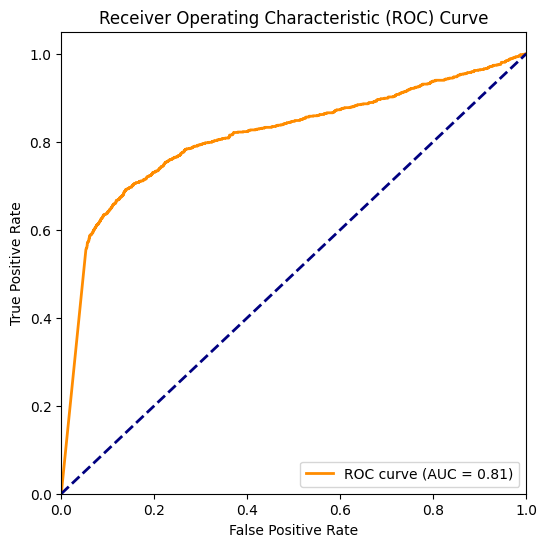

In [59]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
vae_labels = get_anomalies_labels(X_long, vq, train_data_long, args, norm=False, group_size=1)
vae_predictions = get_anomalies_prediction(X_long, vq, train_data_long, args, norm=False, group_size=1, threshold=40)

for i, (label, pred) in enumerate(zip(vae_labels, vae_predictions)):
    print(label.shape)
    print(len(np.where(label==False)[0]))
    accuracy = accuracy_score(label, pred)
    print(accuracy)
    recall = recall_score(label.T, pred.T, average='macro')
    print(recall)
    f1 = f1_score(label.T, pred.T, average='macro')
    print(f1)

    fpr, tpr, thresholds = roc_curve(label, y_scores[i], drop_intermediate=False)
    print(tpr.shape)
    roc_auc = auc(fpr, tpr)   # roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


In [37]:
Origin.cpu().numpy().ndim

2

In [8]:
Origin, REC, _ = rebuild_TS_non_overlapping(vq, train_data_long, args, keep_norm=False)
# plt.plot(abs(Origin-REC))
    
    # Calculate rec loss
rec_loss = (REC - Origin)**2
# plt.plot(rec_loss)

In [ ]:
vae_labels = get_anomalies_labels(X_long, vae, train_data_long, args)
vae_predictions = get_anomalies_prediction(X_long, vae, train_data_long, args)
vae_predictions.shape

In [9]:
from sklearn.mixture import GaussianMixture
y_scores = []
for i in range(args.n_channels):
    gmm = GaussianMixture(n_components=2, random_state=0)  # You can adjust the number of components
    gmm.fit(rec_loss[:,i].reshape(-1, 1).cpu().numpy())

    # Get the estimated probabilities of being in each component
    outlier_probabilities = gmm.predict_proba(rec_loss[:,i].reshape(-1, 1).cpu().numpy())[:, 0]  # Probability of being in the first component
    y_scores.append(1-outlier_probabilities)

In [24]:
outlier_probabilities.shape

(83520,)

In [25]:
rec_loss.shape

torch.Size([83520, 2])

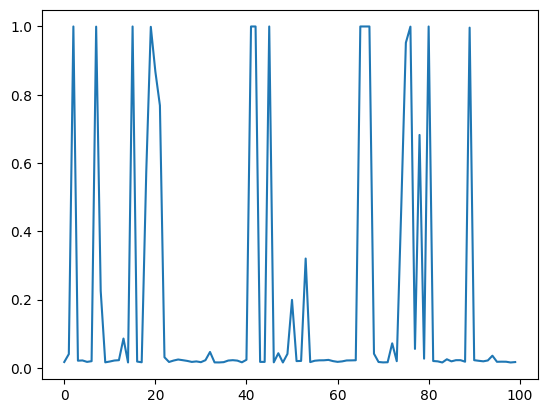

In [60]:
plt.plot(1-outlier_probabilities[:100])

In [64]:
#Create a mask for the anomalies
anomalies_mask = np.full(outlier_probabilities.shape, False)

for channel in range(args.n_channels):
    anomalies = np.where(1-outlier_probabilities > 0.8)[0]
    anomalies_mask[anomalies] = True

# Reduce the size of mask (grouped values)
anomalies_reshaped_mask = anomalies_mask.reshape(-1, 1)
predictions = np.any(anomalies_reshaped_mask, axis=1)

In [85]:
anomalies.shape
some_anomalies = np.where(anomalies<100)[0]
sector_anomalies = anomalies[some_anomalies]

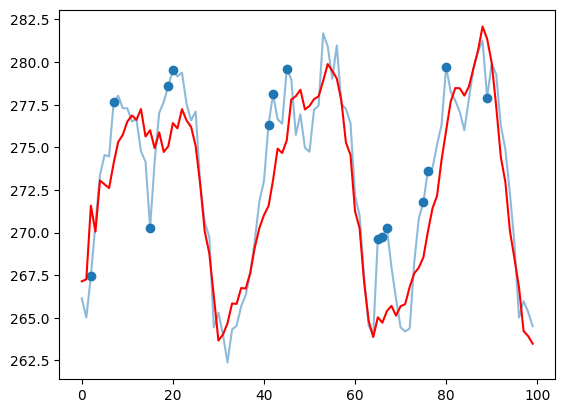

In [86]:
plt.plot(Origin.cpu()[:100], alpha=0.5)
plt.plot(REC.cpu()[:100], "-r")
plt.scatter(sector_anomalies, Origin[sector_anomalies].cpu())